In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

In [44]:
train_df = pd.read_csv('processed_train_df.csv')
train_df = train_df[['Entity', 'en_content', 'Sentiment']]
train_df.columns = ['Entity', 'Content', 'Sentiment']
train_df

,Entity,Content,Sentiment
0,Borderlands,"['i', 'be', 'come', 'to', 'the', 'border', 'an...",Positive
1,Borderlands,"['i', 'be', 'get', 'on', 'borderland', 'and', ...",Positive
2,Borderlands,"['i', 'be', 'come', 'on', 'borderland', 'and',...",Positive
3,Borderlands,"['i', 'be', 'get', 'on', 'borderland', '2', 'a...",Positive
4,Borderlands,"['i', 'be', 'get', 'into', 'borderland', 'and'...",Positive
...,...,...,...
51468,Nvidia,"['my', 'be', 'no', 'highlight', 'picture', 're...",Positive
51469,Nvidia,"['just', 'realize', 'that', 'my', 'mac', 'wind...",Positive
51470,Nvidia,"['just', 'realize', 'the', 'window', 'partitio...",Positive
51471,Nvidia,"['just', 'realize', 'between', 'the', 'window'...",Positive


In [45]:
test_df = pd.read_csv('processed_test_df.csv')
test_df = test_df[['Entity', 'en_content', 'Sentiment']]
test_df.columns = ['Entity', 'Content', 'Sentiment']
test_df

,Entity,Content,Sentiment
0,Amazon,"['broadcasting', 'corporation', 'news', 'amazo...",Neutral
1,Microsoft,"['why', 'do', 'i', 'pay', 'for', 'word', 'when...",Negative
2,CS-GO,"['matchmaking', 'be', 'so', 'full', 'of', 'clo...",Negative
3,Google,"['now', 'the', 'president', 'be', 'slap', 'in'...",Neutral
4,FIFA,"['hi', 'i', 'have', 'in', 'my', 'cellar', 'for...",Negative
...,...,...,...
994,GrandTheftAuto(GTA),"['be', 'the', 'art', 'and', 'culture', 'capita...",Irrelevant
995,CS-GO,"['this', 'be', 'actually', 'a', 'good', 'move'...",Irrelevant
996,Borderlands,"['today', 'suck', 'so', 'it', 's', 'time', 'to...",Positive
997,Microsoft,"['buy', 'a', 'fraction', 'of', 'today', 'small...",Positive


In [46]:
from ast import literal_eval

def combine_list(entity, lst):
    actual_list = literal_eval(lst)
    str_list = ' '.join(actual_list)

    return f'{entity.lower()} : {str_list}'

train_df.loc[:, 'Content'] = train_df.apply(lambda x: combine_list(x['Entity'], x['Content']), axis=1)
test_df.loc[:, 'Content'] = test_df.apply(lambda x: combine_list(x['Entity'], x['Content']), axis=1)

In [8]:
!pip install transformers
!pip install sentencepiece

## XLNET

c:\Users\andrian21\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


63/63 [==============================] - 20s 298ms/step
              precision    recall  f1-score   support

  Irrelevant       0.96      0.80      0.87       171
    Negative       0.96      0.89      0.92       266
     Neutral       0.86      0.92      0.89       285
    Positive       0.85      0.95      0.90       277

    accuracy                           0.90       999
   macro avg       0.91      0.89      0.89       999
weighted avg       0.90      0.90      0.90       999



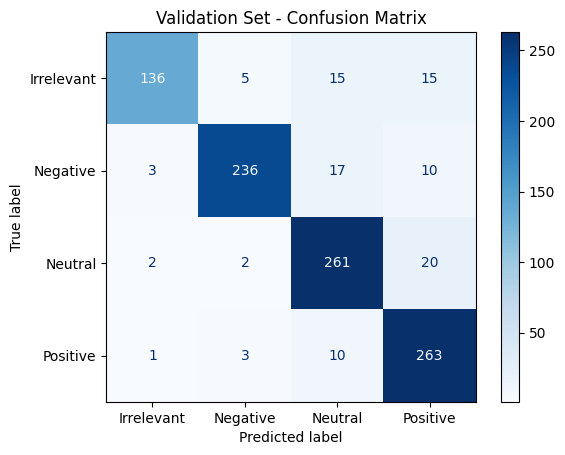

Validation Set - Confusion Matrix:
[[136   5  15  15]
 [  3 236  17  10]
 [  2   2 261  20]
 [  1   3  10 263]]


In [14]:
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetModel
import pandas as pd
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Define the custom layer TFXLNetModel
class TFXLNetModelWrapper(TFXLNetModel, tf.keras.layers.Layer):
    pass

# Load the saved weights with custom objects scope
with tf.keras.utils.custom_object_scope({'TFXLNetModel': TFXLNetModelWrapper}):
    loaded_model = keras.models.load_model('xlnet.h5')

# Load and preprocess the validation data
data_val = test_df[['Content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

val_texts = data_val['Content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the validation texts
val_encodings = tokenizer(val_texts, truncation=True, padding=False, max_length=64)

val_input_ids = pad_sequences(val_encodings['input_ids'], maxlen=64, padding='post')
val_attention_mask = pad_sequences(val_encodings['attention_mask'], maxlen=64, padding='post')

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create a TensorFlow dataset for validation
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_input_ids, 'attention_mask': val_attention_mask}, val_labels_encoded))

# Evaluate the loaded model on the validation dataset
val_predictions = loaded_model.predict(val_dataset.batch(16))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the validation set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)

# Generate the confusion matrix for the validation set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

save_folder = 'xlnet'
os.makedirs(save_folder, exist_ok=True)

# Save classification report to a file
val_report_path = os.path.join(save_folder, 'validation_classification_report.txt')
with open(val_report_path, 'w') as file:
    file.write("Validation Set - Classification Report:\n")
    file.write(val_classification_rep)

# Plot and save the confusion matrix
print(val_classification_rep)
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
val_image_path = os.path.join(save_folder, 'validation_confusion_matrix.png')
plt.savefig(val_image_path)
plt.show()



In [26]:
test_df = pd.read_csv('processed_test_df.csv')
test_df = test_df[['Entity', 'Content', 'en_content', 'Sentiment']]
test_df.columns = ['Entity', 'Ori', 'Content', 'Sentiment']
test_df

,Entity,Ori,Content,Sentiment
0,Amazon,BBC News - Amazon boss Jeff Bezos rejects clai...,"['broadcasting', 'corporation', 'news', 'amazo...",Neutral
1,Microsoft,@Microsoft Why do I pay for WORD when it funct...,"['why', 'do', 'i', 'pay', 'for', 'word', 'when...",Negative
2,CS-GO,"CSGO matchmaking is so full of closet hacking,...","['matchmaking', 'be', 'so', 'full', 'of', 'clo...",Negative
3,Google,Now the President is slapping Americans in the...,"['now', 'the', 'president', 'be', 'slap', 'in'...",Neutral
4,FIFA,Hi @EAHelp I’ve had Madeleine McCann in my cel...,"['hi', 'i', 'have', 'in', 'my', 'cellar', 'for...",Negative
...,...,...,...,...
994,GrandTheftAuto(GTA),⭐️ Toronto is the arts and culture capital of ...,"['be', 'the', 'art', 'and', 'culture', 'capita...",Irrelevant
995,CS-GO,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,"['this', 'be', 'actually', 'a', 'good', 'move'...",Irrelevant
996,Borderlands,Today sucked so it’s time to drink wine n play...,"['today', 'suck', 'so', 'it', 's', 'time', 'to...",Positive
997,Microsoft,Bought a fraction of Microsoft today. Small wins.,"['buy', 'a', 'fraction', 'of', 'today', 'small...",Positive


In [33]:
# Specify the file path
misclassified_file_path = 'misclassified_xlnet_en.txt'

# Find misclassified examples
misclassified_indices = np.where(val_predicted_labels != val_labels)[0]

# Write details of misclassified examples to a file
with open(misclassified_file_path, 'w', encoding='utf-8') as file:  # Specify UTF-8 encoding
    file.write("Misclassified Examples:\n")
    file.write("\n")

    for idx in misclassified_indices:
        true_label = val_true_labels.iloc[idx]
        predicted_label = val_predicted_sentiments[idx]
        content = test_df.loc[idx]['Content']
        file.write(f"Example {idx + 1} - True Label: {true_label}, Predicted Label: {predicted_label}\n")
        file.write(f"Content: {content}\n")
        file.write("\n")

print(f"Misclassified examples details have been written to: {misclassified_file_path}")


Misclassified examples details have been written to: misclassified_xlnet_en.txt


## BERT

In [52]:
!pip install --upgrade tensorflow transformers


     ---------------------------------------- 0.0/126.8 kB ? eta -:--:--
     -------------------------------------- 126.8/126.8 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
   -- ------------------------------------- 0.6/8.2 MB 11.5 MB/s eta 0:00:01
   ---------- ----------------------------- 2.1/8.2 MB 21.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.2 MB 37.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.2 MB 37.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.2 MB 37.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.2 MB 37.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.2 MB 37.1 MB/s eta 0:00:01
   -------------------------------- ------- 6.7/8.2 MB 17.8 MB/s eta 0:00:01
   ---------------------------------------- 8.2/8.2 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.

22/22 [==============================] - 13s 533ms/step
              precision    recall  f1-score   support

  Irrelevant       0.74      0.68      0.71       171
    Negative       0.82      0.78      0.80       266
     Neutral       0.79      0.74      0.76       285
    Positive       0.72      0.84      0.77       277

    accuracy                           0.77       999
   macro avg       0.77      0.76      0.76       999
weighted avg       0.77      0.77      0.77       999



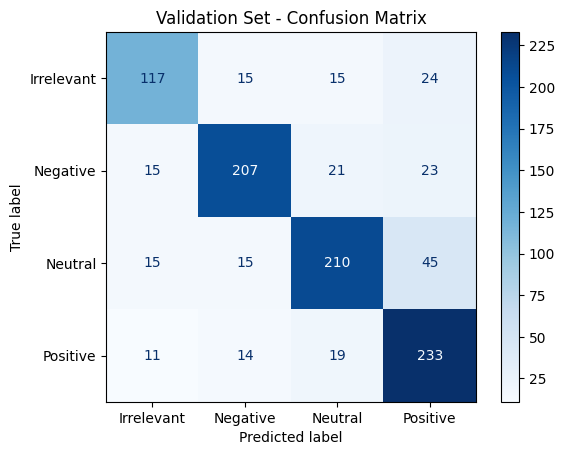

In [60]:
import tensorflow as tf
import pandas as pd
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

from transformers import BertTokenizer, TFBertModel

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the custom layer TFBertModel
class TFBertModelWrapper(TFBertModel, tf.keras.layers.Layer):
    pass

# Load the saved weights with custom objects scope
with tf.keras.utils.custom_object_scope({'TFBertModel': TFBertModelWrapper}):
    loaded_model = keras.models.load_model('bert.h5')  # Replace 'bert.h5' with the actual file name of your saved BERT model


# Load and preprocess the validation data
data_val = test_df[['Content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

val_texts = data_val['Content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the validation texts
val_encodings = tokenizer(val_texts, truncation=True, padding=False, max_length=46)

val_input_ids = pad_sequences(val_encodings['input_ids'], maxlen=46, padding='post')
val_attention_mask = pad_sequences(val_encodings['attention_mask'], maxlen=46, padding='post')

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create a TensorFlow dataset for validation
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_input_ids, 'attention_mask': val_attention_mask}, val_labels_encoded))

# Evaluate the loaded model on the validation dataset
val_predictions = loaded_model.predict(val_dataset.batch(16))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the validation set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)

# Generate the confusion matrix for the validation set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

save_folder = 'Bert'
os.makedirs(save_folder, exist_ok=True)

# Save classification report to a file
val_report_path = os.path.join(save_folder, 'validation_classification_report.txt')
with open(val_report_path, 'w') as file:
    file.write("Validation Set - Classification Report:\n")
    file.write(val_classification_rep)

# Plot and save the confusion matrix
print(val_classification_rep)
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
val_image_path = os.path.join(save_folder, 'validation_confusion_matrix.png')
plt.savefig(val_image_path)
plt.show()



In [ ]:
# Specify the file path
misclassified_file_path = 'misclassified_xlnet_en.txt'

# Find misclassified examples
misclassified_indices = np.where(val_predicted_labels != val_labels)[0]

# Write details of misclassified examples to a file
with open(misclassified_file_path, 'w', encoding='utf-8') as file:  # Specify UTF-8 encoding
    file.write("Misclassified Examples:\n")
    file.write("\n")

    for idx in misclassified_indices:
        true_label = val_true_labels.iloc[idx]
        predicted_label = val_predicted_sentiments[idx]
        content = test_df.loc[idx]['Content']
        file.write(f"Example {idx + 1} - True Label: {true_label}, Predicted Label: {predicted_label}\n")
        file.write(f"Content: {content}\n")
        file.write("\n")

print(f"Misclassified examples details have been written to: {misclassified_file_path}")
